In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import gc

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, Embedding, GlobalAveragePooling2D

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#from utils import get_model, find_closest, get_sequences, create_train_valid,  generate_output, guess_human

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
pd.set_option('max_colwidth', -1)

Using TensorFlow backend.


In [2]:
data_original = pd.read_csv('data_rec.csv', sep = ';')
print(data_original.shape)
data_original.head()

(11826, 12)


,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime
0,MRS pablo98,QC9CY9JC,78.0,SLO - Movistar Riders,9242429.0,3Musk,Challenge,"skeletons,the-log,ice-golem,fireball,hunter,dark-prince,royal-hogs,three-musketeers",24.0,7.0,16.0,2019-05-11 09:08:59.0000000
1,Arctic Periko,88JQL8RR,77.0,SLO - Arctic Gaming,9242888.0,BridgeSpam,Challenge,"ice-golem,giant-snowball,bandit,minions,inferno-dragon,fireball,dark-prince,battle-ram",10.0,4.0,6.0,2019-05-11 09:06:07.0000000
2,VGIA Rouber,RRJVLQ2Q,11.0,SLO - Vodafone Giants,9245246.0,Golem,Challenge,"barbarian-barrel,tornado,mega-minion,baby-dragon,dark-prince,prince,electro-dragon,golem",1.0,0.0,1.0,2019-05-11 09:02:59.0000000
3,Fernando725,220QQ9R2,80.0,SLO - Cream eSports,9245241.0,PekkaRam,Challenge,"giant-snowball,bandit,minions,dark-prince,electro-wizard,poison,battle-ram,pekka",4.0,0.0,4.0,2019-05-11 08:40:59.0000000
4,GIA Yeray,VPVR8G2,11.0,SLO - Vodafone Giants,9191516.0,RoyalGiant,Match,"barbarian-barrel,guards,mega-minion,baby-dragon,electro-wizard,furnace,lightning,royal-giant",19.0,12.0,7.0,2019-05-11 04:18:26.0000000


### Data cleaning

In [3]:
data_original['date'] = pd.to_datetime(data_original['BattleTime']).dt.date

In [4]:
data_original.dropna(axis = 0, inplace = True)

In [5]:
ints = ['TeamId', 'DeckId', 'Games', 'Losses', 'Wins']
for col in ints:
    data_original[col] = data_original[col].astype(int)
data_original.head()

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date
0,MRS pablo98,QC9CY9JC,78,SLO - Movistar Riders,9242429,3Musk,Challenge,"skeletons,the-log,ice-golem,fireball,hunter,dark-prince,royal-hogs,three-musketeers",24,7,16,2019-05-11 09:08:59.0000000,2019-05-11
1,Arctic Periko,88JQL8RR,77,SLO - Arctic Gaming,9242888,BridgeSpam,Challenge,"ice-golem,giant-snowball,bandit,minions,inferno-dragon,fireball,dark-prince,battle-ram",10,4,6,2019-05-11 09:06:07.0000000,2019-05-11
2,VGIA Rouber,RRJVLQ2Q,11,SLO - Vodafone Giants,9245246,Golem,Challenge,"barbarian-barrel,tornado,mega-minion,baby-dragon,dark-prince,prince,electro-dragon,golem",1,0,1,2019-05-11 09:02:59.0000000,2019-05-11
3,Fernando725,220QQ9R2,80,SLO - Cream eSports,9245241,PekkaRam,Challenge,"giant-snowball,bandit,minions,dark-prince,electro-wizard,poison,battle-ram,pekka",4,0,4,2019-05-11 08:40:59.0000000,2019-05-11
4,GIA Yeray,VPVR8G2,11,SLO - Vodafone Giants,9191516,RoyalGiant,Match,"barbarian-barrel,guards,mega-minion,baby-dragon,electro-wizard,furnace,lightning,royal-giant",19,12,7,2019-05-11 04:18:26.0000000,2019-05-11


### Clean Cards Ids

In [6]:
#print(', '.join(sorted(data_original['CardKeysRaw'][0].split(','))))

In [7]:
data_original['CardKeysRaw'] = data_original['CardKeysRaw'].apply(lambda x: ', '.join(sorted(x.split(','))))

In [8]:
Decks = pd.DataFrame({'deck':data_original['CardKeysRaw']})
print(Decks.shape)
Decks = Decks.groupby('deck').size().to_frame('times').reset_index().sort_values(by = 'times',ascending = False)
print(Decks.shape)
Decks['deck_id_int'] = [id for id in range(Decks.shape[0])]
Decks.head()

(11825, 1)
(4577, 2)


,deck,times,deck_id_int
1134,"balloon, barbarian-barrel, bats, giant-snowball, ice-golem, inferno-tower, miner, rascals",70,0
304,"baby-dragon, bandit, barbarian-barrel, electro-wizard, giant-snowball, pekka, poison, ram-rider",69,1
2311,"barbarian-barrel, bats, giant-snowball, inferno-tower, miner, poison, prince, spear-goblins",66,2
523,"baby-dragon, barbarian-barrel, electro-wizard, furnace, guards, lightning, mega-minion, royal-giant",65,3
1851,"bandit, battle-ram, fireball, giant-snowball, ice-golem, minions, musketeer, prince",65,4


#### Delete redundant Decks 

In [9]:
data_original = pd.merge(data_original, Decks, how = 'inner', left_on = 'CardKeysRaw', right_on = 'deck')
data_original.head(3)

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,deck,times,deck_id_int
0,MRS pablo98,QC9CY9JC,78,SLO - Movistar Riders,9242429,3Musk,Challenge,"dark-prince, fireball, hunter, ice-golem, royal-hogs, skeletons, the-log, three-musketeers",24,7,16,2019-05-11 09:08:59.0000000,2019-05-11,"dark-prince, fireball, hunter, ice-golem, royal-hogs, skeletons, the-log, three-musketeers",5,381
1,S2V RMDavid,Q8P8Q9,76,SLO - S2V eSports,9244593,3Musk,SameClan,"dark-prince, fireball, hunter, ice-golem, royal-hogs, skeletons, the-log, three-musketeers",1,1,0,2019-05-09 20:21:47.0000000,2019-05-09,"dark-prince, fireball, hunter, ice-golem, royal-hogs, skeletons, the-log, three-musketeers",5,381
2,Ruben10,288UCQPG,75,SLO - Team Heretics,9244290,3Musk,SameClan,"dark-prince, fireball, hunter, ice-golem, royal-hogs, skeletons, the-log, three-musketeers",1,1,0,2019-05-09 17:24:52.0000000,2019-05-09,"dark-prince, fireball, hunter, ice-golem, royal-hogs, skeletons, the-log, three-musketeers",5,381


In [10]:
indexNames = data_original[(data_original.Games == 1) & (data_original.times == 1)].index

In [11]:
data_original.drop(axis = 0, index = indexNames, inplace = True)
data_original = data_original.reset_index(drop = True)
data_original.shape

(9611, 16)

### Data preparation

In [12]:
player_unique = data_original.Tag.unique()
teams_unique = data_original.TeamId.unique()
deck_unique = data_original.deck_id_int.unique()
archetype_unique = data_original.Archetype.unique()
usage_unique = data_original.Usage.unique()

print (f'We have {len(player_unique)} unique Players {len(teams_unique)} unique Teams'+\
       f' {len(deck_unique) } unique Decks {len(archetype_unique)} unique Archetypes and {len(usage_unique)} types of usages')

We have 76 unique Players 12 unique Teams 2363 unique Decks 23 unique Archetypes and 4 types of usages


In [13]:
players_map = {i:val for i,val in enumerate(player_unique)}
players_map_inv = {val:i for i,val in enumerate(player_unique)}

teams_map = {i:val for i,val in enumerate(teams_unique)}
teams_map_inv = {val:i for i,val in enumerate(teams_unique)}

decks_map = {i:val for i,val in enumerate(deck_unique)}
decks_map_inv = {val:i for i,val in enumerate(deck_unique)}

archetypes_map = {i:val for i,val in enumerate(archetype_unique)}
archetypes_map_inv = {val:i for i,val in enumerate(archetype_unique)}

usages_map = {i:val for i,val in enumerate(usage_unique)}
usages_map_inv = {val:i for i,val in enumerate(usage_unique)}

In [18]:
my_cols  = ['Player', 'Tag', 'TeamId', 'DeckId', 'Archetype', 'Usage', 'Games', 'Wins', 'Losses', 'CardKeysRaw']
data_feed = data_original[my_cols].copy()

data_feed['Tag'] = data_original['Tag'].map(players_map_inv)
data_feed['TeamId'] = data_original['TeamId'].map(teams_map_inv)
data_feed['deck_id_int'] = data_original['deck_id_int'].map(decks_map_inv)
data_feed['Archetype'] = data_original['Archetype'].map(archetypes_map_inv)
data_feed['Usage'] = data_original['Usage'].map(usages_map_inv)
print(data_feed.shape)
data_feed.head()

(9611, 11)


,Player,Tag,TeamId,DeckId,Archetype,Usage,Games,Wins,Losses,CardKeysRaw,deck_id_int
0,MRS pablo98,0,0,9242429,0,0,24,16,7,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0
1,S2V RMDavid,1,1,9244593,0,1,1,0,1,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0
2,Ruben10,2,2,9244290,0,1,1,0,1,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0
3,SaintBelikin,3,1,9243027,0,1,1,0,1,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0
4,Staze,4,3,9242963,0,2,2,2,0,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0


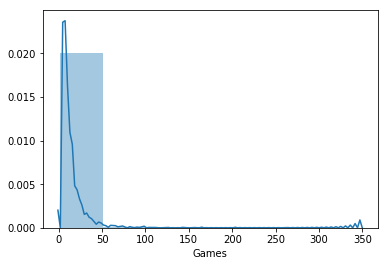

In [19]:
sns.distplot(data_feed['Games'], bins = 7)

## Mapping Cards

In [20]:
data_original['CardKeysRaw'] = data_original['CardKeysRaw'].str.replace('-', '')

In [22]:
MAX_NB_CARDS = 200 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 8 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 8 #Same dim as our W2V embedding

all_cards = data_feed['CardKeysRaw']
all_cards = all_cards.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_CARDS)
tokenizer.fit_on_texts(all_cards)

data_sequences = tokenizer.texts_to_sequences(data_original['CardKeysRaw'])
#data_matrix = tokenizer.
X = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
index_word = dict(map(reversed, tokenizer.word_index.items()))
y = np.array(data_feed['deck_id_int']) 

print('Found %s unique tokens.' % len(word_index))
print (f'There are {len(X)} sequences')
#print(word_index)
#print(data_vec[0])
#print(data_original['CardKeysRaw'].loc[0])

Found 92 unique tokens.
There are 9611 sequences


In [23]:
print(X[4:6])
print(y[4:6])

[[33  6 43 10 41 17 15 75]
 [11 30 33  6  1 10 32 19]]
[0 1]


In [24]:
for i, seq in enumerate(X[4:6]):
    print(i)
    my_cards = []
    for idx in seq:
        my_cards.append(index_word[idx])
        
    print('Features: ' + '-'.join(my_cards))
    print('Label: ' + str(y[i+4]) + '\n')    

0
Features: darkprince-fireball-hunter-icegolem-royalhogs-skeletons-thelog-threemusketeers
Label: 0

1
Features: bandit-battleram-darkprince-fireball-giantsnowball-icegolem-infernodragon-minions
Label: 1



In [25]:
data_feed['Winrate'] = data_feed.Wins / data_feed.Games

In [37]:
def split_train_valid(x, y, rate):
    idx = int(x.shape[0] * rate)
    return x[idx:], y[idx:], x[:idx], y[:idx]
              
X_train, y_train, X_valid, y_valid = split_train_valid(X, y, rate = 0.1)

In [38]:
print(X.shape)
print(X_train.shape)
print(X_valid.shape)

(9611, 8)
(8650, 8)
(961, 8)


## Model architecture

### Output

In [39]:
CAT_DECKS = len(deck_unique)
decks_encoded_train = to_categorical(y_train, num_classes = CAT_DECKS)
decks_encoded_valid = to_categorical(y_valid, num_classes = CAT_DECKS)
#cards_encoded = to_categorical(word_inde, num_classes=len(word_index))
print(decks_encoded_train)
print(decks_encoded_train.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(8650, 2363)


In [40]:
data_feed.head()

,Player,Tag,TeamId,DeckId,Archetype,Usage,Games,Wins,Losses,CardKeysRaw,deck_id_int,Winrate
0,MRS pablo98,0,0,9242429,0,0,24,16,7,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0,0.666667
1,S2V RMDavid,1,1,9244593,0,1,1,0,1,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0,0.000000
2,Ruben10,2,2,9244290,0,1,1,0,1,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0,0.000000
3,SaintBelikin,3,1,9243027,0,1,1,0,1,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0,0.000000
4,Staze,4,3,9242963,0,2,2,2,0,"darkprince, fireball, hunter, icegolem, royalhogs, skeletons, thelog, threemusketeers",0,1.000000


In [41]:
def get_model_Seq():
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=30,
                    weights=None,
                    trainable=True), name = 'Cards')

    # Recurrent layer
    model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1))

    # Fully connected layer
    model.add(Dense(64, activation = 'relu'))

    # Dropout for regularization
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation = 'relu'))
    
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(CAT_DECKS, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

In [42]:
def get_model_classifier(CAT_DECKS):
    player_input = Input(shape=[1], name='player')
    team_input = Input(shape=[1], name='team')
    archetype_input = Input(shape = [1], name = 'archetype')
    usage_input = Input(shape = [1], name = 'usage')
    games_input = Input(shape = [1], name = 'games')
    wins_input = Input(shape = [1], name = 'wins')
    losses_input = Input(shape = [1], name = 'losses')
    deck_input = Input(shape = [1], name = 'deck')
    cards_input = Input(shape = [MAX_SEQUENCE_LENGTH], name = 'cards')

    embedding_size = 10
    deck_embedding_size = 30

    player_embedding = Embedding(output_dim=embedding_size, input_dim = player_unique.shape[0],
                               input_length=1, name='player_embedding')(player_input)
    team_embedding = Embedding(output_dim=embedding_size, input_dim = teams_unique.shape[0],
                               input_length=1, name='team_embedding')(team_input)
    archetype_embedding = Embedding(output_dim=embedding_size, input_dim = archetype_unique.shape[0],
                               input_length=1, name='archetype_embedding')(archetype_input)
    usage_embedding = Embedding(output_dim=embedding_size, input_dim = usage_unique.shape[0],
                               input_length=1, name='usage_embedding')(usage_input)
    deck_embedding = Embedding(output_dim=deck_embedding_size, input_dim = deck_unique.shape[0],
                               input_length=1, name='deck_embedding')(deck_input)
    cards_embedding = Embedding(output_dim=embedding_size, input_dim = len(word_index.keys())+1,
                                name='cards_embedding')(cards_input)


    player_vecs = Reshape([embedding_size])(player_embedding)
    team_vecs = Reshape([embedding_size])(team_embedding)
    arch_vecs = Reshape([embedding_size])(archetype_embedding)
    usage_vecs = Reshape([embedding_size])(usage_embedding)
    #deck_vecs = Reshape([deck_embedding_size])(deck_embedding)
    deck_vecs = LSTM(30, return_sequences = False)(deck_embedding)
    cards_vecs = Flatten()(cards_embedding)

    x1 = concatenate([player_vecs, team_vecs, arch_vecs, usage_vecs, deck_vecs,
                     wins_input, losses_input, games_input, cards_vecs], name = 'VECTOR_INTERACCION')
    #############################################
    x2 = Dropout(0.4)(x1)
    x3 = Dense (64, activation = 'relu')(x2)
    x4 = Dropout(0.3)(x3)
    x5 = Dense (32, activation = 'relu')(x4)
    x6 = Dropout(0.3)(x5)
    ############################################
    output = Dense(CAT_DECKS, activation = 'softmax', name = 'DECKS')(x6)
    reg1 = Dense(32, activation = 'relu')(x1)
    outreg = Dense(1, activation = 'sigmoid', name = 'WINRATE')(reg1)
    ############################################
    
    model = Model(inputs=[player_input, team_input, archetype_input, usage_input, games_input, wins_input,
                         losses_input, deck_input, cards_input] , 
                  outputs = [output, outreg])

    model.compile(loss = ['categorical_crossentropy', 'binary_crossentropy'],
                  optimizer = 'rmsprop',
                  metrics = ['acc'])

    model.summary()
    
    return model

In [43]:
data_feed.columns

Index(['Player', 'Tag', 'TeamId', 'DeckId', 'Archetype', 'Usage', 'Games',
       'Wins', 'Losses', 'CardKeysRaw', 'deck_id_int', 'Winrate'],
      dtype='object')

In [51]:
model = get_model_Seq()

# Sequence

#class_weights = {0: 1.0, 1: 2.0}

history = model.fit(X_train,
                    decks_encoded_train,
                    validation_data = (X_valid, decks_encoded_valid), 
                    epochs = 60, class_weight = None,
                    batch_size = 64, shuffle = True, verbose = 1)

# Classifier
#history = model.fit([data_feed['Tag'], data_feed['TeamId'], data_feed['Archetype'], data_feed['Usage'],
#                    data_feed['Games'], data_feed['Wins'], data_feed['Losses'], data_feed['deck_id_int'], data_vec],
#                    [decks_encoded, data_feed['Winrate']], 
#                    epochs = 4, validation_split = 0.1,
#                    batch_size = 64, 
#                    shuffle = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 30)          2790      
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 2363)              77979     
Total para

8650/8650 [==============================] - 3s 355us/step - loss: 3.6070 - acc: 0.2434 - val_loss: 15.9972 - val_acc: 0.0031
Epoch 51/60
8650/8650 [==============================] - 3s 359us/step - loss: 3.6362 - acc: 0.2394 - val_loss: 16.0405 - val_acc: 0.0031
Epoch 52/60
8650/8650 [==============================] - 3s 362us/step - loss: 3.6047 - acc: 0.2400 - val_loss: 16.0587 - val_acc: 0.0031
Epoch 53/60
8650/8650 [==============================] - 3s 371us/step - loss: 3.5977 - acc: 0.2427 - val_loss: 16.0515 - val_acc: 0.0031
Epoch 54/60
8650/8650 [==============================] - 4s 478us/step - loss: 3.5711 - acc: 0.2477 - val_loss: 16.0584 - val_acc: 0.0031
Epoch 55/60
8650/8650 [==============================] - 4s 417us/step - loss: 3.5277 - acc: 0.2558 - val_loss: 16.0621 - val_acc: 0.0031
Epoch 56/60
8650/8650 [==============================] - 4s 421us/step - loss: 3.5001 - acc: 0.2516 - val_loss: 16.0664 - val_acc: 0.0031
Epoch 57/60
8650/8650 [=======================

In [52]:
pred = model.predict(X_valid, verbose = 1)

961/961 [==============================] - 1s 661us/step


In [55]:
print(pred.shape)
print(pred[0].shape)

(961, 2363)
(2363,)


In [53]:
pred[0].argsort()[-5:][::-1]

array([ 831, 1454,  649, 1595,  449], dtype=int64)

In [65]:
y_valid[103]

5